In [1]:
import clip
from __future__ import print_function
import glob
from itertools import chain
import os
import cv2
import csv
import random
import zipfile
import os.path as osp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from functools import reduce
import torch.nn as nn
from einops import rearrange, repeat
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import pandas as pd
from torchvision.transforms import ToPILImage
# from linformer import Linformer
from PIL import Image
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
# from vit_pytorch.efficient import ViT
# from model import BiSeNet
import torchvision.transforms as transforms
from skimage import io, img_as_float
import timm
from sklearn.metrics import log_loss, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import seaborn as sns


In [2]:
seed = 17
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [3]:
device = 'cuda'
# device = 'cpu'

In [40]:
# directory/folder path
real_dir_path = r'../Datasets/ICMRDataset/validation/progan_withclassnamesasprefixes/0_real/'
# list to store files
real_image_paths = []
# Iterate directory
for file_path in os.listdir(real_dir_path):
    real_image_paths.append(os.path.join(real_dir_path, file_path))
print(len(real_image_paths))

4000


In [50]:
# directory/folder path
fake_dir_path = r'../Datasets/ICMRDataset/validation/progan_withclassnamesasprefixes/1_fake/'
# list to store files
fake_image_paths = []
# Iterate directory
for file_path in os.listdir(fake_dir_path):
    fake_image_paths.append(os.path.join(fake_dir_path, file_path))
print(len(fake_image_paths))

4000


In [51]:
# # directory/folder path
# fake_dir_path_2 = r'D:/Research/PhD/Year3/DeepfakeDetection/Datasets/diffusion_datasets/glide_100_10_compressed/jpeg_10/1_fake/'
# # list to store files
# fake_image_paths_2 = []
# # Iterate directory
# for file_path in os.listdir(fake_dir_path_2):
#     fake_image_paths_2.append(os.path.join(fake_dir_path_2, file_path))
# print(len(fake_image_paths_2))

In [52]:
# fake_image_paths_2[0].split('/')[-3]

In [53]:
all_paths = []
all_paths.extend(real_image_paths[:200])
all_paths.extend(fake_image_paths[:200])
# all_paths.extend(fake_image_paths_2[:250])
len(all_paths)

400

In [9]:
# directory/folder path
real_dir_path = r'../Datasets/diffusion_datasets/laion/0_real/'
# list to store files
real_image_paths = []
# Iterate directory
for file_path in os.listdir(real_dir_path):
    real_image_paths.append(os.path.join(real_dir_path, file_path))
print(len(real_image_paths))

# directory/folder path
fake_dir_path = r'../Datasets/diffusion_datasets/glide_100_10/1_fake/'
# list to store files
fake_image_paths = []
# Iterate directory
for file_path in os.listdir(fake_dir_path):
    fake_image_paths.append(os.path.join(fake_dir_path, file_path))
print(len(fake_image_paths))

all_paths = []
all_paths.extend(real_image_paths[:250])
all_paths.extend(fake_image_paths[:250])
# all_paths.extend(fake_image_paths_2[:250])
len(all_paths)

1000
1000


500

# Unicom 

In [11]:
import unicom

In [19]:
unicom.available_models()
model, preprocess = unicom.load('ViT-L/14')
model.cuda()

In [54]:
model.eval()
def get_features(all_paths):
    outputs = []
    labels_int = []
    for i in range(len(all_paths)):
        img_path = all_paths[i]
        image = cv2.imread(img_path)
        # image = cv2_jpg(image, 50)
        # image = add_noise(image, 0.4)
        image = Image.fromarray(image)
        preprocessed_image = preprocess(image)
#         tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
#                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
#         preprocessed_image = tfms(image)
        with torch.no_grad():
            features = model(preprocessed_image.unsqueeze(0).to(device)).flatten(0)
            outputs.append(features.cpu().numpy())
        if 'real' in img_path.split('/')[-2]:
            labels_int.append(0)
        else:
            labels_int.append(1)
    
    torch.cuda.empty_cache()
    return outputs, labels_int

In [55]:
features, labels = get_features(all_paths)

C:\Users\Sohail\.conda\envs\open-mmlab\lib\site-packages\torch\utils\checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [56]:
features = np.array(features)
labels = np.array(labels)

In [57]:
tsne = TSNE(n_components=2, verbose=1, perplexity=90, n_iter=450)
tsne_results = tsne.fit_transform(features)

[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.001s...
[t-SNE] Computed neighbors for 400 samples in 0.029s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 1.156708
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.917789
[t-SNE] KL divergence after 450 iterations: 0.762346


(-7.394966292381286, 7.510493922233581, -6.196834564208984, 5.977683067321777)

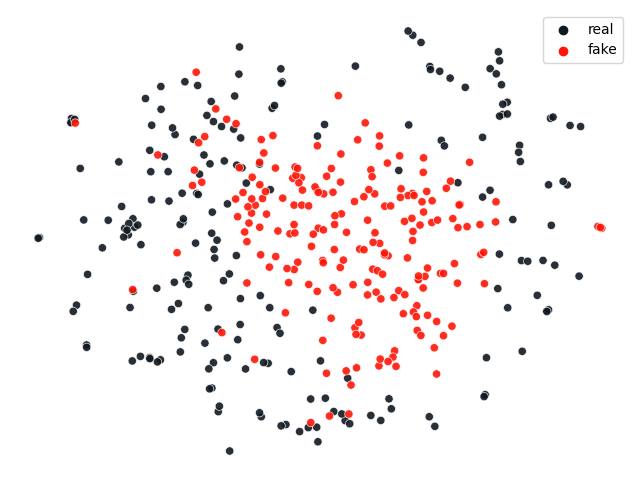

In [58]:
labels_map = ['real', 'fake']
all_text_labels = []
all_text_labels = [str(item).replace('0', 'real') for item in labels]
all_text_labels = [str(item).replace('1', 'fake') for item in all_text_labels]

df = pd.DataFrame()

df['tsne_2d_one'] = tsne_results[:,0]
df['tsne_2d_two'] = tsne_results[:,1]
colors = ['#101820FF', '#FF1607']
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='tsne_2d_one', y='tsne_2d_two',
    hue=all_text_labels,
    palette=customPalette,
    data=df,
    legend="full",
    alpha=0.9
)
plt.axis('off')
# plt.savefig("clip_real_fake_tsne_output.png", bbox_inches='tight', pad_inches=0, dpi=300)

# CLIP Experiments

In [74]:
model, preprocess = clip.load('ViT-L/14', device)

# model = timm.create_model('xception', pretrained=True, num_classes=2).to(device)
# # model.load_state_dict(torch.load(model_path), strict=True)
# model.reset_classifier(0)
# model.to(device)
# model.eval()

# model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14').to(device)

In [75]:
def cv2_jpg(img, compress_val):
    img_cv2 = img[:,:,::-1]
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), compress_val]
    result, encimg = cv2.imencode('.jpg', img_cv2, encode_param)
    decimg = cv2.imdecode(encimg, 1)
    return decimg[:,:,::-1]

def add_noise(image, noise_level):
    # Generate random noise with the same shape as the image
    noise = np.random.normal(scale=noise_level, size=image.shape).astype(np.uint8)
    # Add noise to the image
    noisy_image = cv2.add(image, noise)
    # Clip the values to ensure they are within the valid range [0, 255]
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return noisy_image

In [210]:
def get_features(all_paths):
    outputs = []
    labels_int = []
    for i in range(len(all_paths)):
        img_path = all_paths[i]
        image = cv2.imread(img_path)
        # image = cv2_jpg(image, 50)
        # image = add_noise(image, 0.4)
        image = Image.fromarray(image)
        preprocessed_image = preprocess(image)
#         tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
#                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
#         preprocessed_image = tfms(image)
        with torch.no_grad():
            features = model.encode_image(preprocessed_image.unsqueeze(0).to(device)).flatten(0)
            outputs.append(features.cpu().numpy())
        if 'real' in img_path.split('/')[-2]:
            labels_int.append(0)
        else:
            labels_int.append(1)
    
    torch.cuda.empty_cache()
    return outputs, labels_int

In [211]:
features, labels = get_features(all_paths)

In [212]:
features = np.array(features)
labels = np.array(labels)

In [213]:
tsne = TSNE(n_components=2, verbose=1, perplexity=90, n_iter=450)
tsne_results = tsne.fit_transform(features)

[t-SNE] Computing 200 nearest neighbors...
[t-SNE] Indexed 201 samples in 0.000s...
[t-SNE] Computed neighbors for 201 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 201 / 201
[t-SNE] Mean sigma: 5.653489
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.025597
[t-SNE] KL divergence after 450 iterations: 0.398134


(-3.457361400127411,
 3.066947877407074,
 -3.2852537035942078,
 2.8745660185813904)

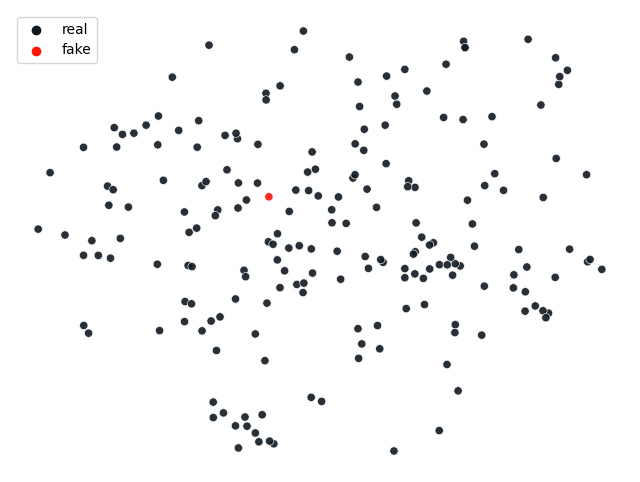

In [214]:
labels_map = ['real', 'fake']
all_text_labels = []
all_text_labels = [str(item).replace('0', 'real') for item in labels]
all_text_labels = [str(item).replace('1', 'fake') for item in all_text_labels]

df = pd.DataFrame()

df['tsne_2d_one'] = tsne_results[:,0]
df['tsne_2d_two'] = tsne_results[:,1]
colors = ['#101820FF', '#FF1607']
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='tsne_2d_one', y='tsne_2d_two',
    hue=all_text_labels,
    palette=customPalette,
    data=df,
    legend="full",
    alpha=0.9
)
plt.axis('off')
# plt.savefig("clip_real_fake_tsne_output.png", bbox_inches='tight', pad_inches=0, dpi=300)

# KNN

In [177]:
import torch
# from torchvision.models import CLIP
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=17)

# Train KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=17)
knn_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 86.25%


In [178]:
y_pred

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0])

In [179]:
y_test

array([0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0])

# Supervised

In [67]:
model_sup = timm.create_model('vit_large_patch16_224.augreg_in21k', pretrained=True, num_classes=2).to(device)
# model.load_state_dict(torch.load(model_path), strict=True)
model_sup.reset_classifier(0)
model_sup.to(device)
model_sup.eval()

# model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14').to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (

In [150]:
def get_features(all_paths):
    outputs = []
    labels_int = []
    for i in range(len(all_paths)):
        img_path = all_paths[i]
        image = Image.open(img_path)
#         preprocessed_image = preprocess(image)
        tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
               transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        preprocessed_image = tfms(image)
        with torch.no_grad():
            features = model_sup(preprocessed_image.unsqueeze(0).to(device)).flatten(0)
            outputs.append(features.cpu().numpy())
        if 'real' in img_path.split('/')[-2]:
            labels_int.append(0)
        else:
            labels_int.append(1)
    
    torch.cuda.empty_cache()
    return outputs, labels_int

In [151]:
features, labels = get_features(all_paths)

In [152]:
features = np.array(features)
labels = np.array(labels)

In [72]:
tsne = TSNE(n_components=2, verbose=1, perplexity=90, n_iter=450)
tsne_results = tsne.fit_transform(features)

[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 30.246594
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.904358
[t-SNE] KL divergence after 450 iterations: 0.535295


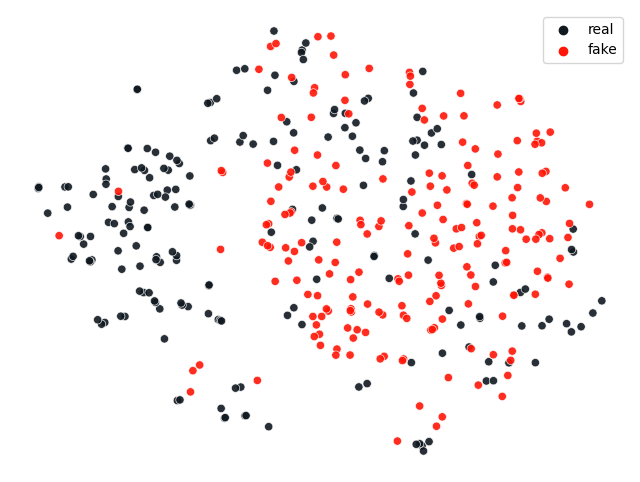

In [73]:
labels_map = ['real', 'fake']
all_text_labels = []
all_text_labels = [str(item).replace('0', 'real') for item in labels]
all_text_labels = [str(item).replace('1', 'fake') for item in all_text_labels]

df = pd.DataFrame()

df['tsne_2d_one'] = tsne_results[:,0]
df['tsne_2d_two'] = tsne_results[:,1]
colors = ['#101820FF', '#FF1607']
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='tsne_2d_one', y='tsne_2d_two',
    hue=all_text_labels,
    palette=customPalette,
    data=df,
    legend="full",
    alpha=0.9
)
plt.axis('off')
plt.savefig("Supervised_with_legend_tsne_output.png", bbox_inches='tight', pad_inches=0, dpi=300)

# plt.figure(figsize=(8,6))
# sns.scatterplot(
#     x='tsne_2d_one', y='tsne_2d_two',
#     hue=all_text_labels,
#     palette=customPalette,
#     data=df,
#     legend=False,
#     alpha=0.9
# )
# plt.axis('off')
# plt.savefig("tsne_visualizations/noaugs/No_legend_tsne_output_" + model_name + '.png', bbox_inches='tight', pad_inches=0, dpi=300)


# DINO V2

In [85]:
# model = timm.create_model('vit_large_patch16_224.augreg_in21k', pretrained=True, num_classes=2).to(device)
# # model.load_state_dict(torch.load(model_path), strict=True)
# model.reset_classifier(0)
# model.to(device)
# model.eval()

dino_v2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14').to(device)


Using cache found in C:\Users\Sohail/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\Sohail/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\Sohail/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\Sohail/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [86]:
dino_v2.eval()
def get_features(all_paths):
    outputs = []
    labels_int = []
    for i in range(len(all_paths)):
        img_path = all_paths[i]
        image = Image.open(img_path)
#         preprocessed_image = preprocess(image)
        tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
               transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        preprocessed_image = tfms(image)
        with torch.no_grad():
            features = dino_v2(preprocessed_image.unsqueeze(0).to(device)).flatten(0)
            outputs.append(features.cpu().numpy())
        if 'fake' in img_path.split('/')[-2]:
            labels_int.append(1)
        else:
            labels_int.append(0)
    
    torch.cuda.empty_cache()
    return outputs, labels_int

In [87]:
features, labels = get_features(all_paths)

TypeError: interpolate() got an unexpected keyword argument 'antialias'

In [56]:
tsne = TSNE(n_components=2, verbose=1, perplexity=90, n_iter=450)
tsne_results = tsne.fit_transform(features)

C:\Users\Sohail\.conda\envs\python_3_gpss\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Sohail\.conda\envs\python_3_gpss\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 14.664792
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.550392
[t-SNE] KL divergence after 450 iterations: 0.973360


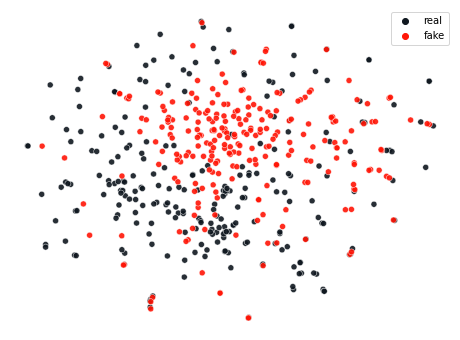

In [57]:
labels_map = ['real', 'fake']
all_text_labels = []
all_text_labels = [str(item).replace('0', 'real') for item in labels]
all_text_labels = [str(item).replace('1', 'fake') for item in all_text_labels]

df = pd.DataFrame()

df['tsne_2d_one'] = tsne_results[:,0]
df['tsne_2d_two'] = tsne_results[:,1]
colors = ['#101820FF', '#FF1607']
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='tsne_2d_one', y='tsne_2d_two',
    hue=all_text_labels,
    palette=customPalette,
    data=df,
    legend="full",
    alpha=0.9
)
plt.axis('off')
plt.savefig("DINOV2_ProGANBirds_with_legend_tsne_output.png", bbox_inches='tight', pad_inches=0, dpi=300)

# plt.figure(figsize=(8,6))
# sns.scatterplot(
#     x='tsne_2d_one', y='tsne_2d_two',
#     hue=all_text_labels,
#     palette=customPalette,
#     data=df,
#     legend=False,
#     alpha=0.9
# )
# plt.axis('off')
# plt.savefig("tsne_visualizations/noaugs/No_legend_tsne_output_" + model_name + '.png', bbox_inches='tight', pad_inches=0, dpi=300)


# DINO V1

In [51]:
model = torch.hub.load('facebookresearch/dino:main', 'dino_vitb16').cuda()

Using cache found in C:\Users\Sohail/.cache\torch\hub\facebookresearch_dino_main


In [52]:
model.eval()
def get_features(all_paths):
    outputs = []
    labels_int = []
    for i in range(len(all_paths)):
        img_path = all_paths[i]
        image = Image.open(img_path)
#         preprocessed_image = preprocess(image)
        tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
               transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        preprocessed_image = tfms(image)
        with torch.no_grad():
            features = model(preprocessed_image.unsqueeze(0).to(device)).flatten(0)
            outputs.append(features.cpu().numpy())
        if 'fake' in img_path.split('/')[-2]:
            labels_int.append(1)
        else:
            labels_int.append(0)
    
    torch.cuda.empty_cache()
    return outputs, labels_int

In [53]:
features, labels = get_features(all_paths)

In [54]:
features = np.array(features)

In [57]:
tsne = TSNE(n_components=2, verbose=1, perplexity=90, n_iter=450)
tsne_results = tsne.fit_transform(features)

[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 19.263955
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.059635
[t-SNE] KL divergence after 450 iterations: 0.506110


(-6.345059752464294, 5.962337374687195, -5.351954174041748, 6.804251384735108)

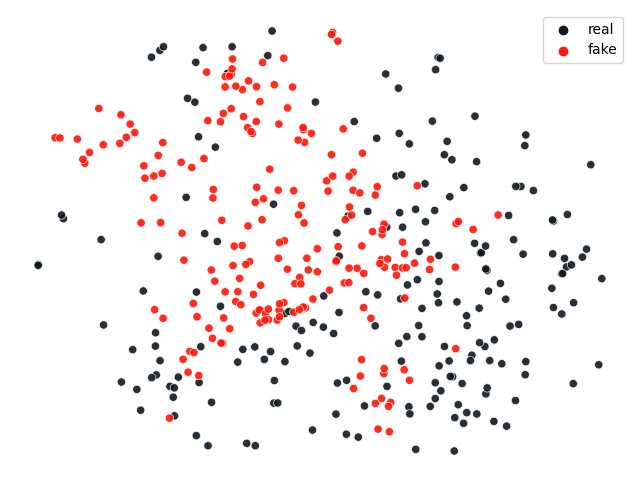

In [58]:
labels_map = ['real', 'fake']
all_text_labels = []
all_text_labels = [str(item).replace('0', 'real') for item in labels]
all_text_labels = [str(item).replace('1', 'fake') for item in all_text_labels]

df = pd.DataFrame()

df['tsne_2d_one'] = tsne_results[:,0]
df['tsne_2d_two'] = tsne_results[:,1]
colors = ['#101820FF', '#FF1607']
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='tsne_2d_one', y='tsne_2d_two',
    hue=all_text_labels,
    palette=customPalette,
    data=df,
    legend="full",
    alpha=0.9
)
plt.axis('off')
# plt.savefig("DINOV1_ProGANBirds_with_legend_tsne_output.png", bbox_inches='tight', pad_inches=0, dpi=300)

# plt.figure(figsize=(8,6))
# sns.scatterplot(
#     x='tsne_2d_one', y='tsne_2d_two',
#     hue=all_text_labels,
#     palette=customPalette,
#     data=df,
#     legend=False,
#     alpha=0.9
# )
# plt.axis('off')
# plt.savefig("tsne_visualizations/noaugs/No_legend_tsne_output_" + model_name + '.png', bbox_inches='tight', pad_inches=0, dpi=300)


# Compress Images

In [29]:
import cv2

In [73]:
# real_image_paths
# fake_image_paths_2
base_path = 'C:/Users/Sohail/Desktop/Research/PhD/Year2/DeepfakeDetection/Datasets/NewDataset_ProGan/diffusion_datasets/laion_compressed/jpeg_75/1_real/'

In [74]:
for i in range(len(real_image_paths)):
    img_name = real_image_paths[i].split('.jpg')[0].split('/')[-1]
    img = cv2.imread(real_image_paths[i])
    jpeg_quality = 75  # A value between 0 and 100 (higher means better quality, but larger file size)
    cv2.imwrite(base_path+ img_name +'.jpg', img, [cv2.IMWRITE_JPEG_QUALITY, jpeg_quality])


In [36]:
real_image_paths[0].split('.jpg')[0].split('/')[-1]

'aadlygmazf'

# EVA CLIP

In [30]:
from os import path
import sys
sys.path.append(path.abspath('.'))
from eva_clip.rei.eva_clip import create_model_and_transforms, get_tokenizer

Please 'pip install xformers'
Please 'pip install xformers'
Please 'pip install apex'
Please 'pip install xformers'


In [31]:
model_name = "EVA02-CLIP-L-14" 
pretrained = "eva02_clip" # or "/path/to/EVA02_CLIP_B_psz16_s8B.pt"

In [32]:
image_path = "CLIP.png"
caption = ["a diagram", "a dog", "a cat"]

device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = create_model_and_transforms(model_name, pretrained, force_custom_clip=True)
# tokenizer = get_tokenizer(model_name)
model = model.to(device)

In [33]:
def get_features(all_paths):
    outputs = []
    labels_int = []
    for i in range(len(all_paths)):
        img_path = all_paths[i]
        image = Image.open(img_path)
        preprocessed_image = preprocess(image)
#         tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
#                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
#         preprocessed_image = tfms(image)
        with torch.no_grad():
            features = model.encode_image(preprocessed_image.unsqueeze(0).to(device)).flatten(0)
            outputs.append(features.cpu().numpy())
        if 'fake' in img_path.split('/')[-2]:
            labels_int.append(1)
        else:
            labels_int.append(0)
    
    torch.cuda.empty_cache()
    return outputs, labels_int

In [34]:
features, labels = get_features(all_paths)

In [35]:
features = np.array(features)

In [36]:
# JPEG 75
tsne = TSNE(n_components=2, verbose=1, perplexity=90, n_iter=450)
tsne_results = tsne.fit_transform(features)

[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.125358
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.948624
[t-SNE] KL divergence after 450 iterations: 0.370247


(-8.07335135936737, 8.930817580223083, -8.644577193260194, 8.439354586601258)

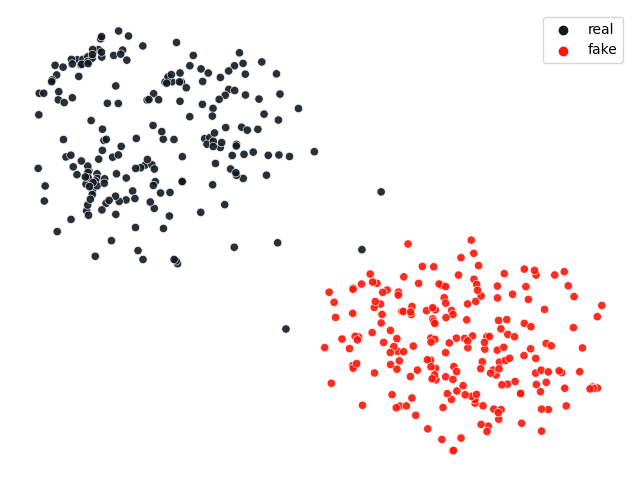

In [37]:
labels_map = ['real', 'fake']
all_text_labels = []
all_text_labels = [str(item).replace('0', 'real') for item in labels]
all_text_labels = [str(item).replace('1', 'fake') for item in all_text_labels]

df = pd.DataFrame()

df['tsne_2d_one'] = tsne_results[:,0]
df['tsne_2d_two'] = tsne_results[:,1]
colors = ['#101820FF', '#FF1607']
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='tsne_2d_one', y='tsne_2d_two',
    hue=all_text_labels,
    palette=customPalette,
    data=df,
    legend="full",
    alpha=0.9
)
plt.axis('off')
# plt.savefig("Compressed_eva_02_clip_real_fake_tsne_output.png", bbox_inches='tight', pad_inches=0, dpi=300)

# OpenCLIP

In [31]:
import torch
from PIL import Image
import open_clip

In [41]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-g-14', pretrained='laion2b_s12b_b42k')
model = model.to(device)

In [60]:
def get_features(all_paths):
    outputs = []
    labels_int = []
    for i in range(len(all_paths)):
        img_path = all_paths[i]
        image = Image.open(img_path)
        preprocessed_image = preprocess(image)
#         tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
#                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
#         preprocessed_image = tfms(image)
        with torch.no_grad():
            features = model.encode_image(preprocessed_image.unsqueeze(0).to(device)).flatten(0)
            outputs.append(features.cpu().numpy())
        if 'fake' in img_path.split('/')[-2]:
            labels_int.append(1)
        else:
            labels_int.append(0)
    
    torch.cuda.empty_cache()
    return outputs, labels_int

In [61]:
features, labels = get_features(all_paths)

In [53]:
tsne = TSNE(n_components=2, verbose=1, perplexity=90, n_iter=450)
tsne_results = tsne.fit_transform(features)

C:\Users\Sohail\.conda\envs\python_3_gpss\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Sohail\.conda\envs\python_3_gpss\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 8.865546
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.859753
[t-SNE] KL divergence after 450 iterations: 0.861759


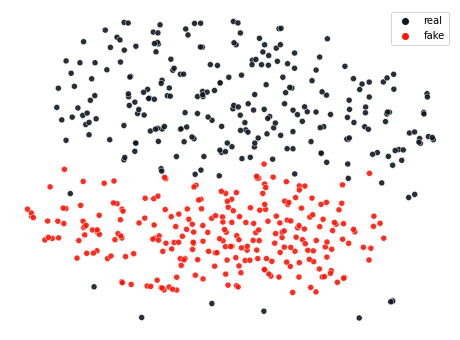

In [54]:
labels_map = ['real', 'fake']
all_text_labels = []
all_text_labels = [str(item).replace('0', 'real') for item in labels]
all_text_labels = [str(item).replace('1', 'fake') for item in all_text_labels]

df = pd.DataFrame()

df['tsne_2d_one'] = tsne_results[:,0]
df['tsne_2d_two'] = tsne_results[:,1]
colors = ['#101820FF', '#FF1607']
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='tsne_2d_one', y='tsne_2d_two',
    hue=all_text_labels,
    palette=customPalette,
    data=df,
    legend="full",
    alpha=0.9
)
plt.axis('off')
plt.savefig("open_clip_G_real_fake_tsne_output.png", bbox_inches='tight', pad_inches=0, dpi=300)

In [44]:
# JPEG 75
tsne = TSNE(n_components=2, verbose=1, perplexity=90, n_iter=450)
tsne_results = tsne.fit_transform(features)

C:\Users\Sohail\.conda\envs\python_3_gpss\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Sohail\.conda\envs\python_3_gpss\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.028s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 8.653966
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.655113
[t-SNE] KL divergence after 450 iterations: 0.915414


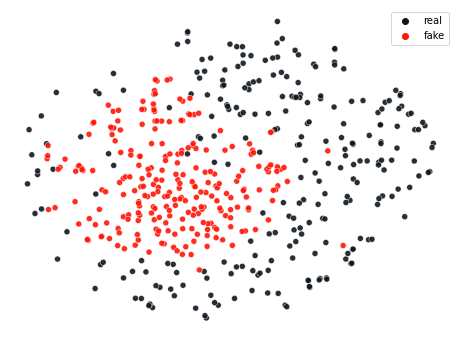

In [45]:
labels_map = ['real', 'fake']
all_text_labels = []
all_text_labels = [str(item).replace('0', 'real') for item in labels]
all_text_labels = [str(item).replace('1', 'fake') for item in all_text_labels]

df = pd.DataFrame()

df['tsne_2d_one'] = tsne_results[:,0]
df['tsne_2d_two'] = tsne_results[:,1]
colors = ['#101820FF', '#FF1607']
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='tsne_2d_one', y='tsne_2d_two',
    hue=all_text_labels,
    palette=customPalette,
    data=df,
    legend="full",
    alpha=0.9
)
plt.axis('off')
plt.savefig("Compressed_open_clip_G_real_fake_tsne_output.png", bbox_inches='tight', pad_inches=0, dpi=300)

In [65]:
# JPEG 10
tsne = TSNE(n_components=2, verbose=1, perplexity=90, n_iter=450)
tsne_results = tsne.fit_transform(features)

C:\Users\Sohail\.conda\envs\python_3_gpss\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Sohail\.conda\envs\python_3_gpss\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 8.366278
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.762760
[t-SNE] KL divergence after 450 iterations: 0.939049


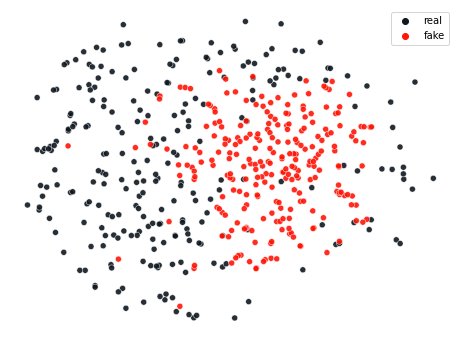

In [66]:
labels_map = ['real', 'fake']
all_text_labels = []
all_text_labels = [str(item).replace('0', 'real') for item in labels]
all_text_labels = [str(item).replace('1', 'fake') for item in all_text_labels]

df = pd.DataFrame()

df['tsne_2d_one'] = tsne_results[:,0]
df['tsne_2d_two'] = tsne_results[:,1]
colors = ['#101820FF', '#FF1607']
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='tsne_2d_one', y='tsne_2d_two',
    hue=all_text_labels,
    palette=customPalette,
    data=df,
    legend="full",
    alpha=0.9
)
plt.axis('off')
plt.savefig("Compressed_10_open_clip_G_real_fake_tsne_output.png", bbox_inches='tight', pad_inches=0, dpi=300)

# BEIT

In [1]:
from os import path
import sys
sys.path.append(path.abspath('./beit/'))
from beit.getBEIT import createBEIT, load_model

C:\Users\Sohail\Desktop\Research\PhD\Year3\DeepfakeDetection\ICMR\beit\modeling_finetune.py:379: UserWarning: Overwriting beit_base_patch16_224 in registry with modeling_finetune.beit_base_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def beit_base_patch16_224(pretrained=False, **kwargs):
C:\Users\Sohail\Desktop\Research\PhD\Year3\DeepfakeDetection\ICMR\beit\modeling_finetune.py:388: UserWarning: Overwriting beit_base_patch16_384 in registry with modeling_finetune.beit_base_patch16_384. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def beit_base_patch16_384(pretrained=False, **kwargs):
C:\Users\Sohail\Desktop\Research\PhD\Year3\DeepfakeDetection\ICMR\beit\modeling_finetune.py:397: UserWarning: Overwriting beit_large_patch16_224 in registry with modeling_finetune.beit_large_patch16_224. This is because the name being registered conflicts 

In [2]:
# pretraining weights load
# model = createBEIT()
# checkpoint_file='./beit/pretrained_weights/beit_large_patch16_224_pt22k.pth'
# checkpoint = torch.load(
#     checkpoint_file, map_location="cpu"
# )
# model.load_state_dict(checkpoint["model"])

In [3]:
model = createBEIT()
checkpoint_file='./beit/pretrained_weights/beit_large_patch16_224_pt22k_ft22k.pth'
load_model(model=model, checkpoint_file=checkpoint_file, model_key='model|module|', model_prefix="")

C:\Users\Sohail\.conda\envs\open-mmlab\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Load state_dict by model_key = model
Weights of VisionTransformer not initialized from pretrained model: ['pos_embed', 'rel_pos_bias.relative_position_bias_table']
Weights from pretrained model not used in VisionTransformer: ['blocks.0.attn.relative_position_bias_table', 'blocks.0.attn.relative_position_index', 'blocks.1.attn.relative_position_bias_table', 'blocks.1.attn.relative_position_index', 'blocks.2.attn.relative_position_bias_table', 'blocks.2.attn.relative_position_index', 'blocks.3.attn.relative_position_bias_table', 'blocks.3.attn.relative_position_index', 'blocks.4.attn.relative_position_bias_table', 'blocks.4.attn.relative_position_index', 'blocks.5.attn.relative_position_bias_table', 'blocks.5.attn.relative_position_index', 'blocks.6.attn.relative_position_bias_table', 'blocks.6.attn.relative_position_index', 'blocks.7.attn.relative_position_bias_table', 'blocks.7.attn.relative_position_index', 'blocks.8.attn.relative_position_bias_table', 'blocks.8.attn.relative_position

In [18]:
model.to('cuda')
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0, inplace=False)
  (rel_pos_bias): RelativePositionBias()
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=False)
        (attn_drop): Dropout(p=0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affi

In [39]:
def get_features(all_paths):
    outputs = []
    labels_int = []
    for i in range(len(all_paths)):
        img_path = all_paths[i]
        image = Image.open(img_path)
        image = image.convert('RGB')
        tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
               transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        preprocessed_image = tfms(image)
        with torch.no_grad():
            features = model(preprocessed_image.unsqueeze(0).to(device)).flatten(0)
            outputs.append(features.cpu().numpy())
        if 'real' in img_path.split('/')[-2]:
            labels_int.append(0)
        else:
            labels_int.append(1)
    
    torch.cuda.empty_cache()
    return outputs, labels_int

In [40]:
features, labels = get_features(all_paths)

In [41]:
features = np.array(features)

In [42]:
tsne = TSNE(n_components=2, verbose=1, perplexity=90, n_iter=450)
tsne_results = tsne.fit_transform(features)

[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.027s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 6.896145
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.243225
[t-SNE] KL divergence after 450 iterations: 0.336410


(-8.533659148216248, 10.74337832927704, -5.274811220169068, 4.807202768325806)

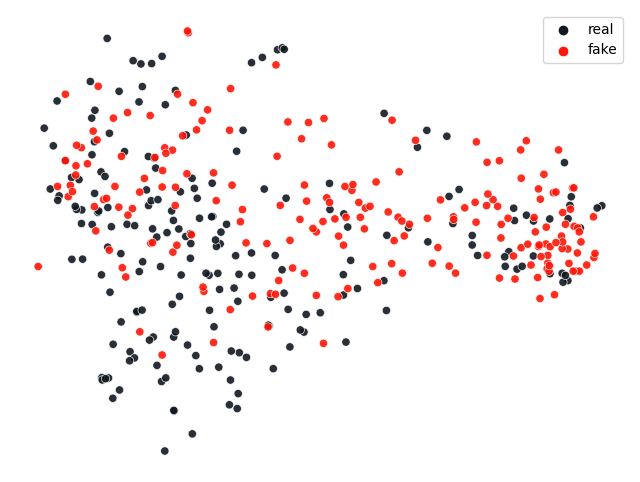

In [43]:
labels_map = ['real', 'fake']
all_text_labels = []
all_text_labels = [str(item).replace('0', 'real') for item in labels]
all_text_labels = [str(item).replace('1', 'fake') for item in all_text_labels]

df = pd.DataFrame()

df['tsne_2d_one'] = tsne_results[:,0]
df['tsne_2d_two'] = tsne_results[:,1]
colors = ['#101820FF', '#FF1607']
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='tsne_2d_one', y='tsne_2d_two',
    hue=all_text_labels,
    palette=customPalette,
    data=df,
    legend="full",
    alpha=0.9
)
plt.axis('off')
# plt.savefig("beit_real_fake_tsne_output.png", bbox_inches='tight', pad_inches=0, dpi=300)

In [10]:
from transformers import AutoImageProcessor, BeitModel, BeitForMaskedImageModeling
import torch
from datasets import load_dataset

In [11]:
image_processor = AutoImageProcessor.from_pretrained("microsoft/beit-large-patch16-224-pt22k")
model = BeitModel.from_pretrained("microsoft/beit-large-patch16-224-pt22k")
model.to('cuda')

preprocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

C:\Users\Sohail\.conda\envs\open-mmlab\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in D:\ModelWeightsCache\huggingface\hub\models--microsoft--beit-large-patch16-224-pt22k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Could not find image processor class in the image processor config or the model config. 

config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of BeitModel were not initialized from the model checkpoint at microsoft/beit-large-patch16-224-pt22k and are newly initialized: ['beit.pooler.layernorm.weight', 'beit.pooler.layernorm.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BeitModel(
  (embeddings): BeitEmbeddings(
    (patch_embeddings): BeitPatchEmbeddings(
      (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): BeitEncoder(
    (relative_position_bias): BeitRelativePositionBias()
    (layer): ModuleList(
      (0): BeitLayer(
        (attention): BeitAttention(
          (attention): BeitSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=False)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): BeitSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): BeitIntermediate(
          (dense): Linear(in_features=1024, out_featu

In [12]:
def get_features(all_paths):
    output = []
    labels_int = []
    for i in range(len(all_paths)):
        img_path = all_paths[i]
        image = Image.open(img_path)
        image = image.convert('RGB')
#         tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
#                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#         preprocessed_image = tfms(image)
        inputs = image_processor(image, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs.to('cuda'))
#             print(outputs[1].flatten(0).shape)
            output.append(outputs[1].flatten(0).cpu().numpy())
        if 'fake' in img_path.split('/')[-2]:
            labels_int.append(1)
        else:
            labels_int.append(0)
    
    torch.cuda.empty_cache()
    return output, labels_int

In [13]:
features, labels = get_features(all_paths)

In [14]:
features = np.array(features)

In [15]:
tsne = TSNE(n_components=2, verbose=1, perplexity=90, n_iter=450)
tsne_results = tsne.fit_transform(features)

[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.202s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 5.017049
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.243279
[t-SNE] KL divergence after 450 iterations: 0.571957


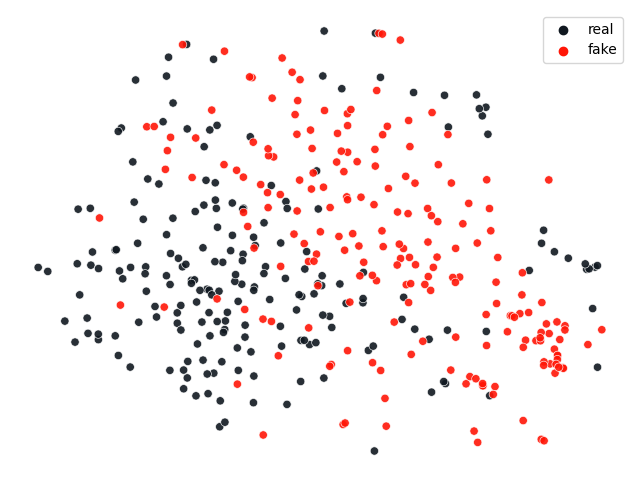

In [16]:
labels_map = ['real', 'fake']
all_text_labels = []
all_text_labels = [str(item).replace('0', 'real') for item in labels]
all_text_labels = [str(item).replace('1', 'fake') for item in all_text_labels]

df = pd.DataFrame()

df['tsne_2d_one'] = tsne_results[:,0]
df['tsne_2d_two'] = tsne_results[:,1]
colors = ['#101820FF', '#FF1607']
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='tsne_2d_one', y='tsne_2d_two',
    hue=all_text_labels,
    palette=customPalette,
    data=df,
    legend="full",
    alpha=0.9
)
plt.axis('off')
plt.savefig("beit_real_fake_tsne_output.png", bbox_inches='tight', pad_inches=0, dpi=300)

# MAE

In [9]:
from os import path
import sys
sys.path.append(path.abspath('./mae/'))
from mae.getMAE import createMAE
from mae.util.pos_embed import interpolate_pos_embed

In [10]:
model = createMAE()

In [11]:
checkpoint = torch.load('./mae/mae_pretrain_vit_large.pth', map_location='cpu')
checkpoint_model = checkpoint['model']
state_dict = model.state_dict()
for k in ['head.weight', 'head.bias']:
    if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
        print(f"Removing key {k} from pretrained checkpoint")
        del checkpoint_model[k]

# interpolate position embedding
interpolate_pos_embed(model, checkpoint_model)

# load pre-trained model
# msg = model.load_state_dict(checkpoint_model, strict=False)
model.load_state_dict(checkpoint_model, strict=True)
model.cuda()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (

In [63]:
def get_features(all_paths):
    outputs = []
    labels_int = []
    for i in range(len(all_paths)):
        img_path = all_paths[i]
        image = Image.open(img_path)
        image = image.convert('RGB')
        tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
               transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        preprocessed_image = tfms(image)
        with torch.no_grad():
            features = model(preprocessed_image.unsqueeze(0).to('cuda'))
#             print(outputs[1].flatten(0).shape)
            outputs.append(features.flatten(0).cpu().numpy())
        if 'dalle' in img_path.split('/')[-3]:
            labels_int.append(1)
        else:
            labels_int.append(0)
    
    torch.cuda.empty_cache()
    return outputs, labels_int

In [64]:
features, labels = get_features(all_paths)
features = np.array(features)

In [65]:
tsne = TSNE(n_components=2, verbose=1, perplexity=90, n_iter=450)
tsne_results = tsne.fit_transform(features)

[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.882325
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.962658
[t-SNE] KL divergence after 450 iterations: 0.468134


(-6.291221761703492, 6.811291837692261, -9.328153777122498, 8.776044535636903)

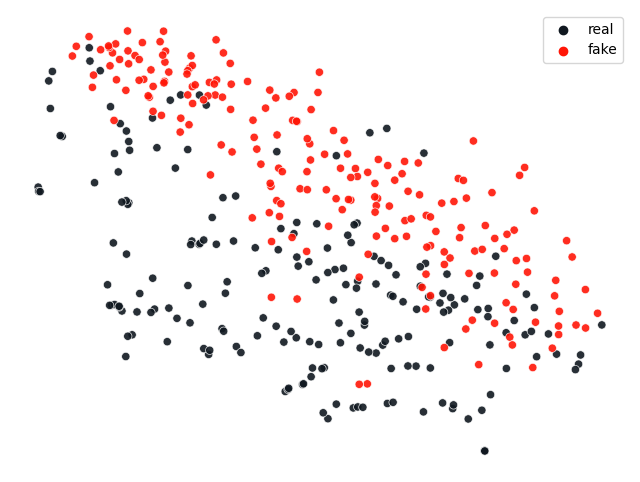

In [66]:
labels_map = ['real', 'fake']
all_text_labels = []
all_text_labels = [str(item).replace('0', 'real') for item in labels]
all_text_labels = [str(item).replace('1', 'fake') for item in all_text_labels]

df = pd.DataFrame()

df['tsne_2d_one'] = tsne_results[:,0]
df['tsne_2d_two'] = tsne_results[:,1]
colors = ['#101820FF', '#FF1607']
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='tsne_2d_one', y='tsne_2d_two',
    hue=all_text_labels,
    palette=customPalette,
    data=df,
    legend="full",
    alpha=0.9
)
plt.axis('off')
# plt.savefig("mae_real_fake_tsne_output.png", bbox_inches='tight', pad_inches=0, dpi=300)

# FFT

In [202]:
# # directory/folder path
# real_dir_path = r'../Datasets/progan_val/horse/0_real/'
# real_dir_path2 = r'../Datasets/progan_val/diningtable/0_real/'
# real_dir_path3 = r'../Datasets/progan_val/dog/0_real/'
# real_dir_path4 = r'../Datasets/progan_val/motorbike//0_real/'
# # list to store files
# real_image_paths = []
# # Iterate directory
# for file_path in os.listdir(real_dir_path):
#     real_image_paths.append(os.path.join(real_dir_path, file_path))

# for file_path in os.listdir(real_dir_path2):
#     real_image_paths.append(os.path.join(real_dir_path2, file_path))
    
# for file_path in os.listdir(real_dir_path3):
#     real_image_paths.append(os.path.join(real_dir_path3, file_path))
    
# print(len(real_image_paths))

# # directory/folder path
# fake_dir_path = r'../Datasets/DiffusionTrainingSet/horse/'
# fake_dir_path2 = r'../Datasets/DiffusionTrainingSet/diningtable/'
# fake_dir_path3 = r'../Datasets/DiffusionTrainingSet/dog/'
# fake_dir_path4 = r'../Datasets/DiffusionTrainingSet/motorbike/'
# # list to store files
# fake_image_paths = []
# # Iterate directory
# for file_path in os.listdir(fake_dir_path):
#     fake_image_paths.append(os.path.join(fake_dir_path, file_path))

# for file_path in os.listdir(fake_dir_path2):
#     fake_image_paths.append(os.path.join(fake_dir_path2, file_path))

# for file_path in os.listdir(fake_dir_path3):
#     fake_image_paths.append(os.path.join(fake_dir_path3, file_path))
    
# print(len(fake_image_paths))

# np.random.shuffle(real_image_paths)
# np.random.shuffle(real_image_paths)
# np.random.shuffle(real_image_paths)
# np.random.shuffle(fake_image_paths)
# np.random.shuffle(fake_image_paths)
# np.random.shuffle(fake_image_paths)


# all_paths = []
# all_paths.extend(real_image_paths[:250])
# all_paths.extend(fake_image_paths[:250])
# # all_paths.extend(fake_image_paths_2[:250])
# len(all_paths)

In [9]:
import cv2

def center_crop(img):
    """Returns center cropped image
    Args:
    img: image to be center cropped
    dim: dimensions (width, height) to be cropped
    """
    dim = [256, 256]
    width, height = img.shape[1], img.shape[0]
    # process crop width and height for max available dimension
    crop_width = dim[0] if dim[0]<img.shape[1] else img.shape[1]
    crop_height = dim[1] if dim[1]<img.shape[0] else img.shape[0] 
    mid_x, mid_y = int(width/2), int(height/2)
    cw2, ch2 = int(crop_width/2), int(crop_height/2) 
    crop_img = img[mid_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2]
    return crop_img

In [5]:
# directory/folder path
real_dir_path = r'../Datasets/diffusion_datasets/laion/0_real/'

# list to store files
real_image_paths = []
# Iterate directory
for file_path in os.listdir(real_dir_path):
    real_image_paths.append(os.path.join(real_dir_path, file_path))  
print(len(real_image_paths))

# directory/folder path
fake_dir_path = r'../Datasets/SDXLTest/1024x1024/1_fake/'
# list to store files
fake_image_paths = []
# Iterate directory
for file_path in os.listdir(fake_dir_path):
    fake_image_paths.append(os.path.join(fake_dir_path, file_path))
print(len(fake_image_paths))

all_paths = []
all_paths.extend(real_image_paths[:250])
all_paths.extend(fake_image_paths[:250])
# all_paths.extend(fake_image_paths_2[:250])
len(all_paths)

1000
1000


500

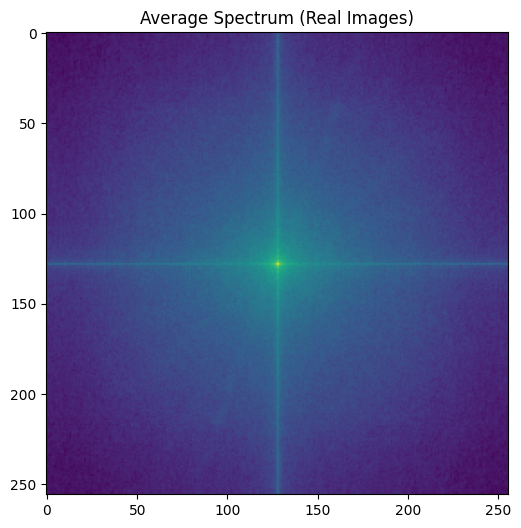

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_average_spectrum(images):
    # Read images and convert to grayscale
    grayscale_images = [cv2.imread(image, cv2.IMREAD_GRAYSCALE) for image in images]
    
    resized_images = []
    for image in grayscale_images:
        if image.shape[0] > 256 or image.shape[1] > 256:
            resized_images.append(center_crop(image))
        else:
            resized_images.append(image)
            
    # Compute FFT for each image
    fft_images = [np.fft.fft2(image) for image in resized_images]

    # Compute average spectrum
    avg_spectrum = np.mean(np.abs(fft_images), axis=0)

    return avg_spectrum

def plot_spectrum(fft_image, title):
    spectrum = np.fft.fftshift(np.log(1 + np.abs(fft_image)))
    plt.figure(figsize = (6,6))
    plt.imshow(spectrum)
    plt.title(title)
    plt.show()

x = compute_average_spectrum(all_paths[:15])
plot_spectrum(x, "Average Spectrum (Real Images)")

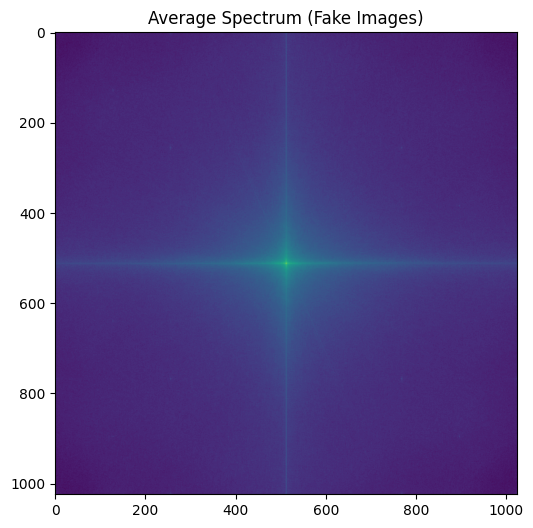

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_average_spectrum(images):
    # Read images and convert to grayscale
    grayscale_images = [cv2.imread(image, cv2.IMREAD_GRAYSCALE) for image in images]

    # Compute FFT for each image
    fft_images = [np.fft.fft2(image) for image in grayscale_images]

    # Compute average spectrum
    avg_spectrum = np.mean(np.abs(fft_images), axis=0)

    return avg_spectrum

def plot_spectrum(fft_image, title):
    spectrum = np.fft.fftshift(np.log(1 + np.abs(fft_image)))
    plt.figure(figsize = (6,6))
    plt.imshow(spectrum)
    plt.title(title)
    plt.show()

y = compute_average_spectrum(all_paths[-15:])
plot_spectrum(y, "Average Spectrum (Fake Images)")

# Image Quality Assesment

In [13]:
import pyiqa
import torch

# list all available metrics
print(pyiqa.list_models())

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


['ahiq', 'brisque', 'ckdn', 'clipiqa', 'clipiqa+', 'clipiqa+_rn50_512', 'clipiqa+_vitL14_512', 'clipscore', 'cnniqa', 'cw_ssim', 'dbcnn', 'dists', 'entropy', 'fid', 'fsim', 'gmsd', 'hyperiqa', 'ilniqe', 'laion_aes', 'liqe', 'liqe_mix', 'lpips', 'lpips-vgg', 'mad', 'maniqa', 'maniqa-kadid', 'maniqa-koniq', 'maniqa-pipal', 'ms_ssim', 'musiq', 'musiq-ava', 'musiq-koniq', 'musiq-paq2piq', 'musiq-spaq', 'nima', 'nima-koniq', 'nima-spaq', 'nima-vgg16-ava', 'niqe', 'nlpd', 'nrqm', 'paq2piq', 'pi', 'pieapp', 'psnr', 'psnry', 'ssim', 'ssimc', 'stlpips', 'stlpips-vgg', 'topiq_fr', 'topiq_fr-pipal', 'topiq_iaa', 'topiq_iaa_res50', 'topiq_nr', 'topiq_nr-face', 'topiq_nr-flive', 'topiq_nr-spaq', 'tres', 'tres-flive', 'tres-koniq', 'uranker', 'vif', 'vsi']


In [14]:
# create metric with default setting
iqa_metric = pyiqa.create_metric('clipiqa+_vitL14_512', device=device)
# Note that gradient propagation is disabled by default. set as_loss=True to enable it as a loss function.
iqa_loss = pyiqa.create_metric('clipiqa+_vitL14_512', device=device, as_loss=True)

# # create metric with custom setting
# iqa_metric = pyiqa.create_metric('psnr', test_y_channel=True, color_space='ycbcr').to(device)

# check if lower better or higher better
print(iqa_metric.lower_better)

Downloading: "https://github.com/chaofengc/IQA-PyTorch/releases/download/v0.1-weights/CLIPIQA+_ViTL14_512-e66488f2.pth" to C:\Users\Sohail\.cache\torch\hub\checkpoints\CLIPIQA+_ViTL14_512-e66488f2.pth



  0%|          | 0.00/463k [00:00<?, ?B/s]

Loading pretrained model CLIPIQA from C:\Users\Sohail\.cache\torch\hub\checkpoints\CLIPIQA+_ViTL14_512-e66488f2.pth
Loading pretrained model CLIPIQA from C:\Users\Sohail\.cache\torch\hub\checkpoints\CLIPIQA+_ViTL14_512-e66488f2.pth
False


In [22]:
# example for iqa score inference
# Tensor inputs, img_tensor_x/y: (N, 3, H, W), RGB, 0 ~ 1
# score_fr = iqa_metric(img_tensor_x, img_tensor_y)
# score_nr = iqa_metric(img_tensor_x)

# img path as inputs.
score = iqa_metric('../Datasets/ICMRDataset/validation/progan_withclassnamesasprefixes/0_real/horse_03313.png')
score

C:\Users\Sohail\.conda\envs\open-mmlab\lib\site-packages\torch\nn\functional.py:3631: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


tensor([[0.6384]], device='cuda:0')

In [26]:
# img path as inputs.
score = iqa_metric('../Datasets/ICMRDataset/validation/progan_withclassnamesasprefixes/1_fake/horse_06249.png')
score

C:\Users\Sohail\.conda\envs\open-mmlab\lib\site-packages\torch\nn\functional.py:3631: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


tensor([[0.7501]], device='cuda:0')

# Noise

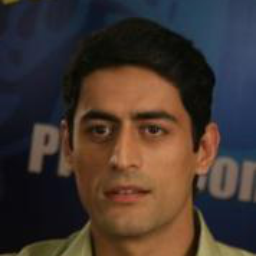

In [49]:
import cv2
import numpy as np

def add_noise(image, noise_level):
    # Generate random noise with the same shape as the image
    noise = np.random.normal(scale=noise_level, size=image.shape).astype(np.uint8)

    # Add noise to the image
    noisy_image = cv2.add(image, noise)

    # Clip the values to ensure they are within the valid range [0, 255]
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    return noisy_image

# Load an image
image = cv2.imread(all_paths[0])
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

# Set the noise level (adjust as needed)
noise_level = 0.4

# Add noise to the image
noisy_image = add_noise(image_rgb, noise_level)
im = Image.fromarray(image_rgb)
im

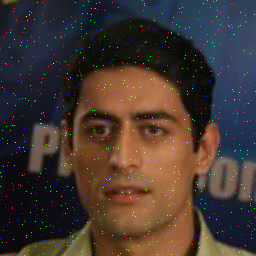

In [50]:
Image.fromarray(noisy_image)

# Blur

In [217]:
# Load an image
image = cv2.imread(all_paths[-1])
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

# Set the Gaussian kernel size (adjust as needed)
kernel_size = (13,13)

# Apply Gaussian blur to the image
blurred_image = cv2.GaussianBlur(image_rgb, kernel_size, 0)

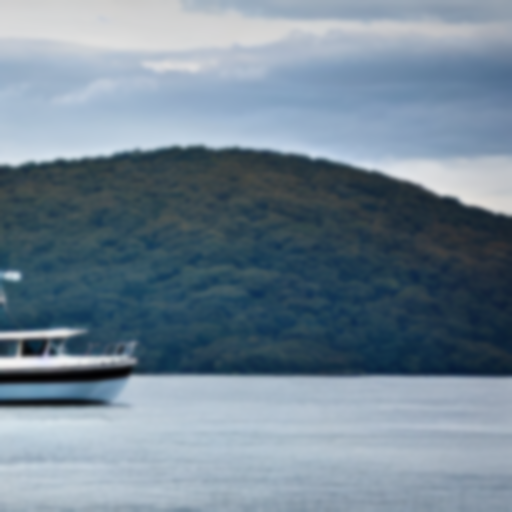

In [218]:
Image.fromarray(blurred_image)

# Mahalanobis

In [180]:
# calculateMahalanobis function to calculate 
# the Mahalanobis distance 
def calculateMahalanobis(y=None, data=None, cov=None): 
  
    y_mu = y - np.mean(data) 
    if not cov: 
        cov = np.cov(data.values.T) 
    inv_covmat = np.linalg.inv(cov) 
    left = np.dot(y_mu, inv_covmat) 
    mahal = np.dot(left, y_mu.T) 
    return mahal.diagonal() 

In [203]:
import torch

def mahalanobis_distance(features, mean, covariance):
    """
    Calculate Mahalanobis distance for a set of features.

    Parameters:
    - features: Tensor of shape (batch_size, feature_dim)
    - mean: Tensor of shape (feature_dim,)
    - covariance: Tensor of shape (feature_dim, feature_dim)

    Returns:
    - mahalanobis_distances: Tensor of shape (batch_size,)
    """
    diff = features - mean
    inv_covariance = torch.inverse(covariance)
    mahalanobis_distances = torch.matmul(diff, torch.matmul(inv_covariance, diff.T))
    return mahalanobis_distances.diag()

# Example usage:
# Assuming 'features' is your feature tensor, 'mean' and 'covariance' are calculated from your dataset
mean = torch.zeros(features[:201].size(-1))
covariance = torch.eye(features[:201].size(-1))

# Calculate Mahalanobis distances
distances = mahalanobis_distance(features[:201], mean, covariance)

print(distances)


tensor([336.5606, 319.9156, 357.6135, 335.1551, 369.8818, 342.7814, 323.6352,
        286.0852, 334.8427, 292.7957, 326.9270, 292.5638, 359.6889, 338.5721,
        371.9900, 286.8987, 316.8235, 301.0621, 371.3389, 350.7381, 302.5209,
        306.7256, 377.7550, 316.0071, 323.3050, 334.7424, 375.1970, 337.8542,
        293.5381, 362.7200, 331.4432, 359.2891, 341.5118, 331.7952, 347.2697,
        314.0363, 323.8813, 303.7863, 313.5792, 324.0656, 335.8066, 374.2693,
        341.0243, 347.6198, 319.8476, 288.4718, 357.0870, 293.2712, 315.0451,
        353.8541, 349.0409, 329.6500, 342.7275, 339.6934, 337.0500, 316.9764,
        353.0612, 274.6948, 331.5488, 327.6121, 357.2929, 293.0444, 351.8438,
        346.3071, 353.9078, 353.5706, 316.3002, 281.1514, 297.4727, 376.8975,
        370.8770, 337.5650, 321.2677, 354.1603, 320.9230, 324.7715, 357.4166,
        286.6702, 330.9156, 329.9727, 336.9652, 330.6378, 348.0885, 300.4847,
        351.1412, 306.5759, 307.0460, 344.9548, 379.3843, 351.66

In [192]:
features = torch.tensor(features)

C:\Users\Sohail\AppData\Local\Temp\ipykernel_27796\787745083.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features)


In [204]:
import torch
import numpy as np
from scipy.stats import chi2

def mahalanobis_p_value(mahalanobis_distances, degrees_of_freedom):
    """
    Calculate p-value for each Mahalanobis distance.

    Parameters:
    - mahalanobis_distances: Tensor of shape (batch_size,)
    - degrees_of_freedom: int, degrees of freedom for the chi-square distribution

    Returns:
    - p_values: Numpy array of shape (batch_size,)
    """
    p_values = 1 - chi2.cdf(mahalanobis_distances.numpy(), df=degrees_of_freedom)
    return p_values

# Example usage:
# Assuming 'mahalanobis_distances' is the tensor of Mahalanobis distances and 'df' is degrees of freedom
df = 201  # Assuming features is a tensor of shape (batch_size, feature_dim)
p_values = mahalanobis_p_value(distances, df)

print(p_values)


[6.57256238e-09 1.87085753e-07 6.83210155e-11 8.80193229e-09
 4.08573175e-12 1.76908921e-09 9.04303145e-08 7.47473982e-05
 9.39005029e-09 2.50391163e-05 4.70302332e-08 2.60247437e-05
 4.27534674e-11 4.31464797e-09 2.49089638e-12 6.56408922e-05
 3.39061435e-07 6.08901130e-06 2.90312219e-12 3.15423576e-10
 4.70938906e-06 2.21874696e-06 6.33604280e-13 3.96109370e-07
 9.65090253e-08 9.58697188e-09 1.16640031e-12 5.01598940e-09
 2.21184534e-05 2.14361862e-11 1.88823871e-08 4.68053374e-11
 2.31846009e-09 1.75729117e-08 6.72998435e-10 5.75069531e-07
 8.61465929e-08 3.76192640e-06 6.26685663e-07 8.30682824e-08
 7.68901076e-09 1.45372603e-12 2.57127253e-09 6.23705865e-10
 1.89566146e-07 5.09499897e-05 7.69095898e-11 2.31285730e-05
 4.75385515e-07 1.58397961e-10 4.57568983e-10 2.71858778e-08
 1.78957482e-09 3.40742934e-09 5.93468452e-09 3.29306389e-07
 1.88876581e-10 4.25625731e-04 1.84796165e-08 4.09974524e-08
 7.34315941e-11 2.40216569e-05 2.47238452e-10 8.29125879e-10
 1.56518132e-10 1.686933

In [208]:
# Assuming you have calculated Mahalanobis distances and p-values as described earlier
# Set a significance level (e.g., 0.05)
significance_level = 0.0000000000001

# Identify outliers based on p-values
outliers = (p_values < significance_level).nonzero()

print("Indices of Outliers:", outliers)


Indices of Outliers: (array([ 93,  99, 107, 112, 142, 147, 170, 200], dtype=int64),)
